##### Copyright 2024 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API Python quickstart

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/tutorials/quickstart_colab"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Google AI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial shows you how to get started with the Gemini API using the Python SDK.

## Prerequisites

You can run this tutorial in Google Colab, which doesn't require additional environment configuration.

Alternatively, to complete this quickstart locally, see the Python guidance in [Get started with the Gemini API](https://ai.google.dev/tutorials/quickstart).

## Install the SDK

The Python SDK for the Gemini API is contained in the [`google-generativeai`](https://pypi.org/project/google-generativeai/) package. Install the dependency using pip:

In [2]:
!pip install -q -U google-generativeai

## Set up your API key

To use the Gemini API, you'll need an API key. If you don't already have one, create a key in Google AI Studio.

<a class="button" href="https://aistudio.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GOOGLE_API_KEY`. Then pass the key to the SDK:

In [3]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

## Initialize the Generative Model

Before you can make any API calls, you need to initialize the Generative Model.

In [4]:
model = genai.GenerativeModel('gemini-2.5-pro')



---



# Pipeline



```
[圖片 Input]
      ↓
[Gemini Vision → 食材偵測 + 菜餚分類]
      ↓
[Halal/Haram 食材比對 → 標註圖片]
      ↓
[RAG 查詢該菜常見隱藏風險]
      ↓
[Decision Layer → 風險等級]
      ↓
[翻譯模組 → 使用者語言]
      ↓
[輸出 → 圖片標註 + 風險摘要 + 替代建議（翻譯後）]

```



## 1. Gemini Vision

In [5]:
from google.genai import types
from PIL import Image
import json
import matplotlib.pyplot as plt

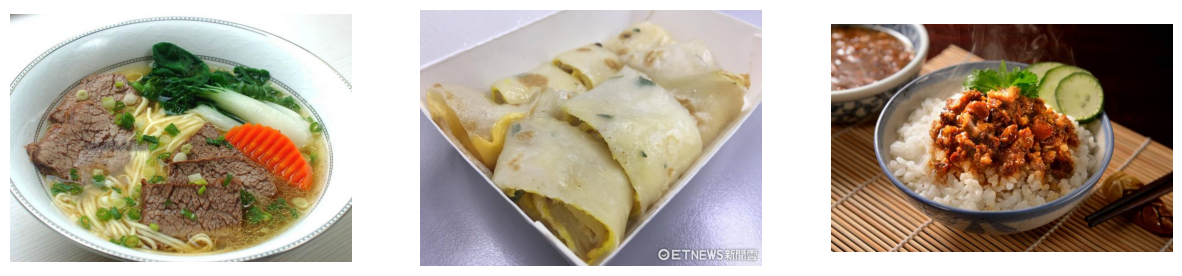

In [6]:
beef_noodle = Image.open("/content/beef_noodle.jpg")
egg_pancake = Image.open("/content/egg_pancake.jpg")
braised_pork_rice = Image.open("/content/braised_pork_rice.jpg")

# show the 3 images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(beef_noodle)
axs[1].imshow(egg_pancake)
axs[2].imshow(braised_pork_rice)

# unable axis
for ax in axs:
    ax.axis('off')

plt.show()

In [7]:
analyze_ingredient_prompt = """
You are a food analyzer. You'll be given an image of Taiwanese cuisine.
Your goal is to analyze the image and list all possible ingredients.
If you cannot detect ingredients visually, first identify the dish name and search the web for its typical recipe.
Also, identify ingredients that are commonly haram in Taiwanese cuisine (like pork, alcohol, or animal-derived oils) in a separate list called 'haram_risks'.
Only list ingredients and potential haram risks. No taste or cultural commentary.
Please return a JSON object with the following format:
{
    "dish": "name of the dish",
    "ingredients": ["ingredient1", "ingredient2", ...],
    "haram_risks": ["ingredient1 may be haram", "ingredient2 may be haram"]
}
Additionally, do not wrap the JSON in ```json``` or any code block. Only return raw JSON.
"""

In [8]:
def analyze_ingredients_and_risk(image):
    response = model.generate_content(
        contents=[image, analyze_ingredient_prompt],
    )

    try:
        result = json.loads(response.text)
        return result

    except json.JSONDecodeError as e:
        print("JSON parsing failed:", e)
        print("Raw response:", response.text)
        return None

```json
{
    'dish': 'Taiwanese Clear-Stewed Beef Noodle Soup (清燉牛肉麵)',
    'ingredients': [
        'Beef',
        'Wheat noodles',
        'Broth',
        'Bok choy',
        'Carrots',
        'Scallions',
        'Ginger',
        'Star anise',
        'Beef bones',
        'Soy sauce',
        'Salt'
    ],
    'haram_risks': [
        'The broth or braising liquid may be made with rice wine (e.g., Shaoxing wine).',
        'The soy sauce may contain alcohol as a preservative.',
        'Risk of cross-contamination with pork products in a non-halal kitchen.',
        'The broth may contain non-halal animal fats or bones.'
    ]
}
```

In [9]:
beef_noodle_ingredients = analyze_ingredients_and_risk(beef_noodle)
beef_noodle_ingredients

{'dish': 'Taiwanese Beef Noodle Soup (清燉牛肉麵 - Clear-Stewed Beef Noodle Soup)',
 'ingredients': ['Beef',
  'Wheat noodles',
  'Bok choy',
  'Carrots',
  'Scallions',
  'Ginger',
  'Garlic',
  'Beef bones',
  'Salt',
  'Water',
  'Soy sauce',
  'Star anise'],
 'haram_risks': ['The beef may not be from a halal (Zabihah) source.',
  'The broth may be prepared with rice wine (e.g., Shaoxing wine, Mijiu).',
  'Soy sauce may contain alcohol as a byproduct of fermentation or as an additive.']}

In [10]:
egg_pancake_ingredients = analyze_ingredients_and_risk(egg_pancake)
egg_pancake_ingredients

{'dish': 'Dan Bing (蛋餅) / Taiwanese Egg Crepe',
 'ingredients': ['Flour',
  'Water',
  'Egg',
  'Green onion',
  'Cheese',
  'Salt',
  'Cooking oil'],
 'haram_risks': ['Lard (豬油) may be used for frying',
  'Cross-contamination from pork products (like ham, bacon, or pork floss) served at the same establishment']}

In [11]:
braised_pork_rice_ingredients = analyze_ingredients_and_risk(braised_pork_rice)
braised_pork_rice_ingredients

{'dish': 'Lu Rou Fan (滷肉飯) / Taiwanese Braised Pork Rice',
 'ingredients': ['Pork belly / Ground pork',
  'Rice',
  'Soy sauce',
  'Rice wine',
  'Fried shallots',
  'Garlic',
  'Rock sugar',
  'Star anise',
  'Five-spice powder',
  'Oil',
  'Water',
  'Cilantro',
  'Cucumber'],
 'haram_risks': ['Pork is not halal.',
  'Rice wine (e.g., Shaoxing wine) is a type of alcohol and not halal.',
  'The oil used for cooking could be lard (pork fat).',
  'Some soy sauces may contain alcohol as a preservative.']}



---



## 2. Halal/Haram Classification

In [18]:
def generate_detect_haram_prompt(ingredients_json):
    prompt = """
    You are a Halal food analyzer. You will be given a JSON object containing:
        - 'dish': the name of a Taiwanese dish
        - 'ingredients': a list of ingredients detected
        - 'haram_risks': a list of potential haram risks associated with the dish

    Your task:
        1. For each ingredient, determine its risk level:
            - 'Safe' → green
            - 'May not be Halal / uncertain' → orange
            - 'Definitely Haram' → red
        2. Return a JSON object containing:
            - 'dish': same as input
            - 'annotated_ingredients': a list of objects with:
                {"ingredient": <name>, "risk": <risk description>, "color": <risk color>}
            - 'summary': a short text describing which ingredients are safe and which are risky, suitable for translation
            Additionally, do not wrap the JSON in ```json``` or any code block. Only return raw JSON.

    Important:
        - Only analyze ingredients listed in the input JSON
        - Use only the information from the input; do not invent new ingredients
        - Return valid JSON only, without code blocks or extra text

    Example output format:

    {
        "dish": "Example Dish",
        "annotated_ingredients": [
            {"ingredient": "Pork", "risk": "Definitely Haram", "color": "red"},
            {"ingredient": "Beef", "risk": "May not be Halal", "color": "orange"},
            {"ingredient": "Rice", "risk": "Safe", "color": "green"}
        ],
        "summary": "Pork is Haram. Beef may not be Halal. Rice is safe."
    }

    Input:
    """
    prompt += json.dumps(ingredients_json)
    return prompt

In [19]:
def analyze_ingredient_haram(ingredients_json):
    prompt = generate_detect_haram_prompt(ingredients_json)
    response = model.generate_content(
        contents=[prompt],
    )

    try:
        result = json.loads(response.text)
        return result

    except json.JSONDecodeError as e:
        print("JSON parsing failed:", e)
        print("Raw response:", response.text)
        return None

```json
{
    'dish': 'Taiwanese Beef Noodle Soup (清燉牛肉麵 - Clear-Stewed Beef Noodle Soup)',
    'annotated_ingredients': [
        {'ingredient': 'Beef', 'risk': 'May not be Halal', 'color': 'orange'},
        {'ingredient': 'Wheat noodles', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Bok choy', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Carrots', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Scallions', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Ginger', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Garlic', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Beef bones', 'risk': 'May not be Halal', 'color': 'orange'},
        {'ingredient': 'Salt', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Water', 'risk': 'Safe', 'color': 'green'},
        {'ingredient': 'Soy sauce', 'risk': 'May not be Halal / uncertain', 'color': 'orange'},
        {'ingredient': 'Star anise', 'risk': 'Safe', 'color': 'green'}
    ],
    'summary': 'Beef, Beef bones, and Soy sauce may not be Halal. Wheat noodles, Bok choy, Carrots, Scallions, Ginger, Garlic, Salt, Water, and Star anise are safe.'
 }
```

In [20]:
beef_noodle_haram = analyze_ingredient_haram(beef_noodle_ingredients)
beef_noodle_haram

{'dish': 'Taiwanese Beef Noodle Soup (清燉牛肉麵 - Clear-Stewed Beef Noodle Soup)',
 'annotated_ingredients': [{'ingredient': 'Beef',
   'risk': 'May not be Halal',
   'color': 'orange'},
  {'ingredient': 'Wheat noodles', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Bok choy', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Carrots', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Scallions', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Ginger', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Garlic', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Beef bones', 'risk': 'May not be Halal', 'color': 'orange'},
  {'ingredient': 'Salt', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Water', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Soy sauce',
   'risk': 'May not be Halal / uncertain',
   'color': 'orange'},
  {'ingredient': 'Star anise', 'risk': 'Safe', 'color': 'green'}],
 'summary': 'Beef, Beef bones, and Soy sauce may not be Halal. Wheat 

In [21]:
egg_pancake_haram = analyze_ingredient_haram(egg_pancake_ingredients)
egg_pancake_haram

{'dish': 'Dan Bing (蛋餅) / Taiwanese Egg Crepe',
 'annotated_ingredients': [{'ingredient': 'Flour',
   'risk': 'Safe',
   'color': 'green'},
  {'ingredient': 'Water', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Egg', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Green onion', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Cheese',
   'risk': 'May not be Halal / uncertain',
   'color': 'orange'},
  {'ingredient': 'Salt', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Cooking oil',
   'risk': 'May not be Halal / uncertain',
   'color': 'orange'}],
 'summary': 'Cooking oil and Cheese may not be Halal. Flour, Water, Egg, Green onion, and Salt are safe. Note the risk of lard being used for frying and cross-contamination.'}

In [22]:
braised_pork_rice_haram = analyze_ingredient_haram(braised_pork_rice_ingredients)
braised_pork_rice_haram

{'dish': 'Lu Rou Fan (滷肉飯) / Taiwanese Braised Pork Rice',
 'annotated_ingredients': [{'ingredient': 'Pork belly / Ground pork',
   'risk': 'Definitely Haram',
   'color': 'red'},
  {'ingredient': 'Rice', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Soy sauce',
   'risk': 'May not be Halal / uncertain',
   'color': 'orange'},
  {'ingredient': 'Rice wine', 'risk': 'Definitely Haram', 'color': 'red'},
  {'ingredient': 'Fried shallots', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Garlic', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Rock sugar', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Star anise', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Five-spice powder', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Oil',
   'risk': 'May not be Halal / uncertain',
   'color': 'orange'},
  {'ingredient': 'Water', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Cilantro', 'risk': 'Safe', 'color': 'green'},
  {'ingredient': 'Cucumber', 'risk': 